# Part A Linear Classification Models

## Import Libraries


In [32]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from src.logistic_regression import LogisticRegression
from src.multiclass_regression import SoftmaxRegression

## A1. DATA PREPARATION




#### Normalizes and Flatten Images

In [3]:
transform_flatten = transforms.Compose([
    transforms.ToTensor(),                   # Convert to tensor & normalizes to [0,1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten 28×28 to 784
])

train_dataset_f = datasets.MNIST(root='./data', train=True, transform=transform_flatten, download=True)
test_dataset_f = datasets.MNIST(root='./data', train=False, transform=transform_flatten, download=True)

#### Split Dataset: 60% train, 20% val, 20% test

In [4]:
idx = list(range(len(train_dataset_f)))
train_idx, temp_idx = train_test_split(idx, test_size=0.40,
                                       stratify=train_dataset_f.targets,
                                       random_state=42)
val_idx, extra_test_idx = train_test_split(temp_idx, test_size=0.50,
                                           stratify=train_dataset_f.targets[temp_idx],
                                           random_state=42)

train_dataset = Subset(train_dataset_f, train_idx)
val_dataset = Subset(train_dataset_f, val_idx)
extra_test_dataset = Subset(train_dataset_f, extra_test_idx)
test_dataset = ConcatDataset([test_dataset_f, extra_test_dataset])

print(f"\nFinal Split:")
print(f"  Training: {len(train_dataset)} ({len(train_dataset)/len(train_dataset_f)*100:.1f}%)")
print(f"  Validation: {len(val_dataset)} ({len(val_dataset)/len(train_dataset_f)*100:.1f}%)")
print(f"  Test: {len(extra_test_idx)} ({len(extra_test_idx)/len(train_dataset_f)*100:.1f}%)")
print(f"  Test: {len(test_dataset)} samples")


Final Split:
  Training: 36000 (60.0%)
  Validation: 12000 (20.0%)
  Test: 12000 (20.0%)
  Test: 22000 samples


## A2. Logistic Regression - Binary Classification


#### Filter only `0` and `1` samples

In [5]:
def filter_binary(dataset, class_a=0, class_b=1):
    binary_data = []
    for x, y in dataset:
        if y in [class_a, class_b]:
            binary_data.append((x, torch.tensor(float(y == class_b))))
    return binary_data

#### Create binary dataset

In [6]:
train_binary = filter_binary(train_dataset, 0, 1)
val_binary = filter_binary(val_dataset, 0, 1)
test_binary = filter_binary(test_dataset, 0, 1)

train_loader_bin = DataLoader(train_binary, batch_size=64, shuffle=True)
val_loader_bin = DataLoader(val_binary, batch_size=64, shuffle=False)
test_loader_bin = DataLoader(test_binary, batch_size=64, shuffle=False)

print(f"Binary dataset sizes:")
print(f"  Train: {len(train_binary)}")
print(f"  Val: {len(val_binary)}")
print(f"  Test: {len(test_binary)}")

Binary dataset sizes:
  Train: 7599
  Val: 2534
  Test: 4647


#### Train Model

In [7]:
bin_model = LogisticRegression(input_dim=28*28) 
bin_model.train(train_loader=train_loader_bin, val_loader=val_loader_bin, epochs=20, lr=0.01)

Epoch 5/20 | Train Loss: 0.0338, Train Acc: 0.9972 | Val Loss: 0.0349, Val Acc: 0.9953
Epoch 10/20 | Train Loss: 0.0204, Train Acc: 0.9979 | Val Loss: 0.0235, Val Acc: 0.9953
Epoch 15/20 | Train Loss: 0.0157, Train Acc: 0.9979 | Val Loss: 0.0192, Val Acc: 0.9957
Epoch 20/20 | Train Loss: 0.0132, Train Acc: 0.9979 | Val Loss: 0.0168, Val Acc: 0.9964


## A3. Softmax Regression - Multi-Class Classification

#### Create multi-class dataset

In [8]:
def prepare_multiclass(dataset):
    data = []
    for x, y in dataset:
        data.append((x, y))
    return data

train_multi = prepare_multiclass(train_dataset)
val_multi = prepare_multiclass(val_dataset)
test_multi = prepare_multiclass(test_dataset)

train_loader_multi = DataLoader(train_multi, batch_size=64, shuffle=True)
val_loader_multi = DataLoader(val_multi, batch_size=64, shuffle=False)
test_loader_multi = DataLoader(test_multi, batch_size=64, shuffle=False)

print(f"Multi-class dataset sizes:")
print(f"  Train: {len(train_multi)}")
print(f"  Val: {len(val_multi)}")
print(f"  Test: {len(test_multi)}")

Multi-class dataset sizes:
  Train: 36000
  Val: 12000
  Test: 22000


#### Train Model

In [9]:
multi_model = SoftmaxRegression(input_dim=28*28, n_classes=10)
multi_model.train(train_loader=train_loader_multi, val_loader=val_loader_multi, epochs=20, lr=0.01)

Epoch 5/20 | Train Loss: 0.4585, Train Acc: 0.8815 | Val Loss: 0.4593, Val Acc: 0.8832
Epoch 10/20 | Train Loss: 0.3858, Train Acc: 0.8951 | Val Loss: 0.3976, Val Acc: 0.8931
Epoch 15/20 | Train Loss: 0.3560, Train Acc: 0.9013 | Val Loss: 0.3717, Val Acc: 0.9002
Epoch 20/20 | Train Loss: 0.3386, Train Acc: 0.9054 | Val Loss: 0.3563, Val Acc: 0.9042


## A4. Evaluation and Visualization

#### Binary Classification - Loss and Accuracy Curves

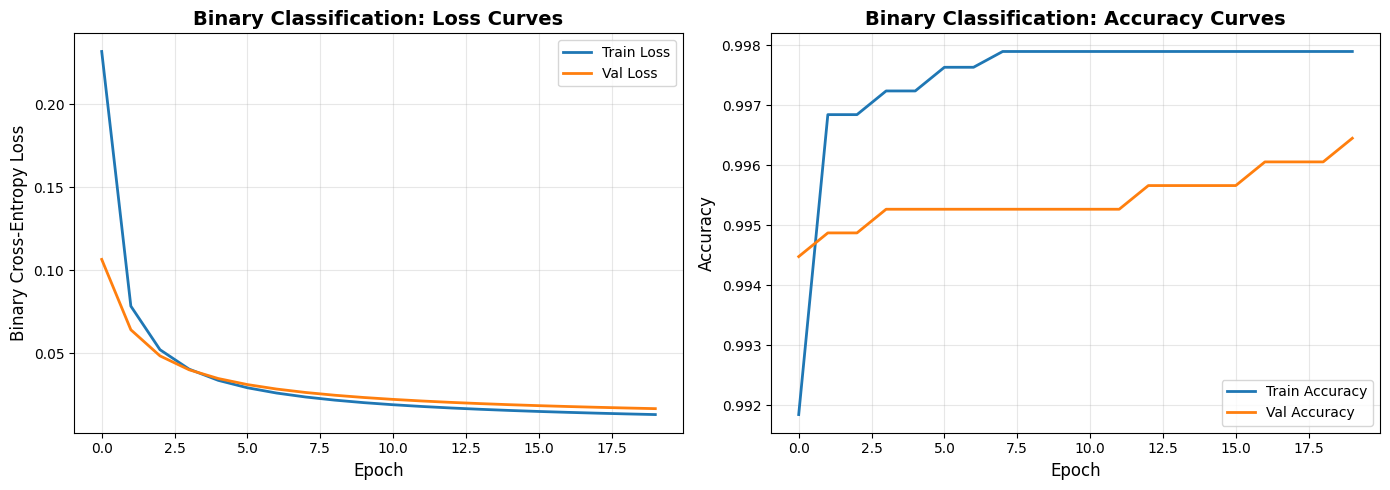

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(bin_model.train_losses_bin, label='Train Loss', linewidth=2)
axes[0].plot(bin_model.val_losses_bin, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Binary Cross-Entropy Loss', fontsize=12)
axes[0].set_title('Binary Classification: Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(bin_model.train_accs_bin, label='Train Accuracy', linewidth=2)
axes[1].plot(bin_model.val_accs_bin, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Binary Classification: Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Multi-class Classification - Loss and Accuracy Curves

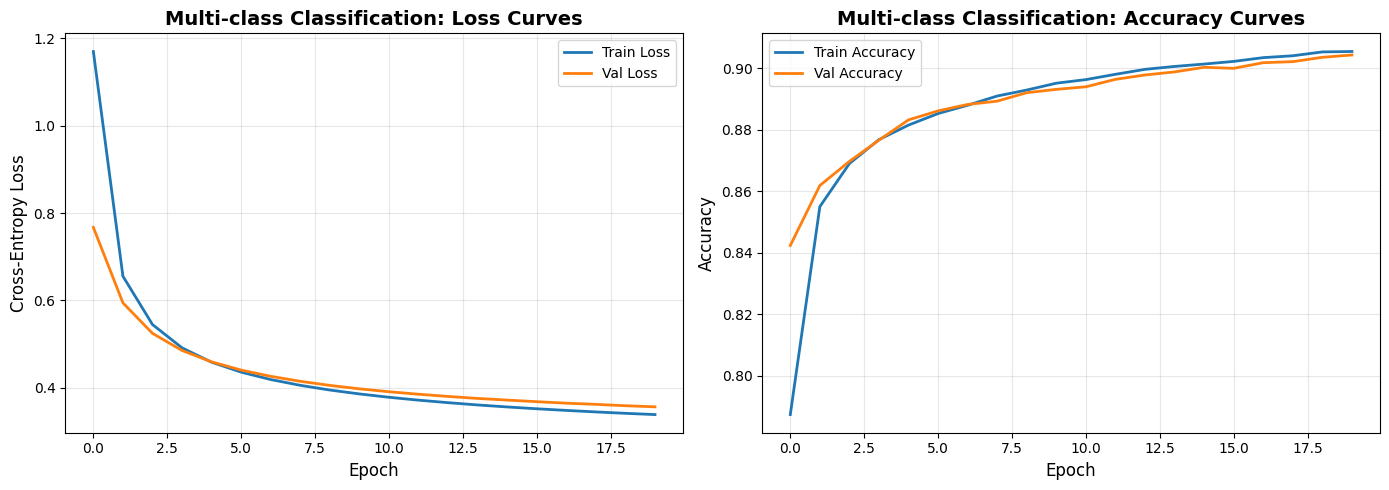

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(multi_model.train_losses_multi, label='Train Loss', linewidth=2)
axes[0].plot(multi_model.val_losses_multi, label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Cross-Entropy Loss', fontsize=12)
axes[0].set_title('Multi-class Classification: Loss Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(multi_model.train_accs_multi, label='Train Accuracy', linewidth=2)
axes[1].plot(multi_model.val_accs_multi, label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Multi-class Classification: Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Test Accuracy

In [34]:
test_acc_bin, test_preds_bin, test_labels_bin = bin_model.evaluate_binary(test_loader_bin)
test_acc_multi, test_preds_multi, test_labels_multi, per_class_acc = multi_model.evaluate_multiclass(test_loader_multi)

# Per-class accuracy table
per_class_df = pd.DataFrame({
    "Digit": [f"{i}" for i in range(len(per_class_acc))],
    "Accuracy": [f"{a:.4f}" for a in per_class_acc]
})

print(f"\nBINARY CLASSIFICATION (0 vs 1)")
print(f"  Test Accuracy: {test_acc_bin:.4f}")

print(f"\nMULTI-CLASS CLASSIFICATION (All 10 digits)")
print(f"  Test Accuracy: {test_acc_multi:.4f}")

print(f"\n Per-Class Accuracy:")
display(per_class_df.style.hide(axis="index"))


BINARY CLASSIFICATION (0 vs 1)
  Test Accuracy: 0.9987

MULTI-CLASS CLASSIFICATION (All 10 digits)
  Test Accuracy: 0.9063

 Per-Class Accuracy:


Digit,Accuracy
0,0.9704
1,0.9686
2,0.8728
3,0.8869
4,0.9131
5,0.8421
6,0.9374
7,0.9040
8,0.8633
9,0.8913


#### Confusion Matrices

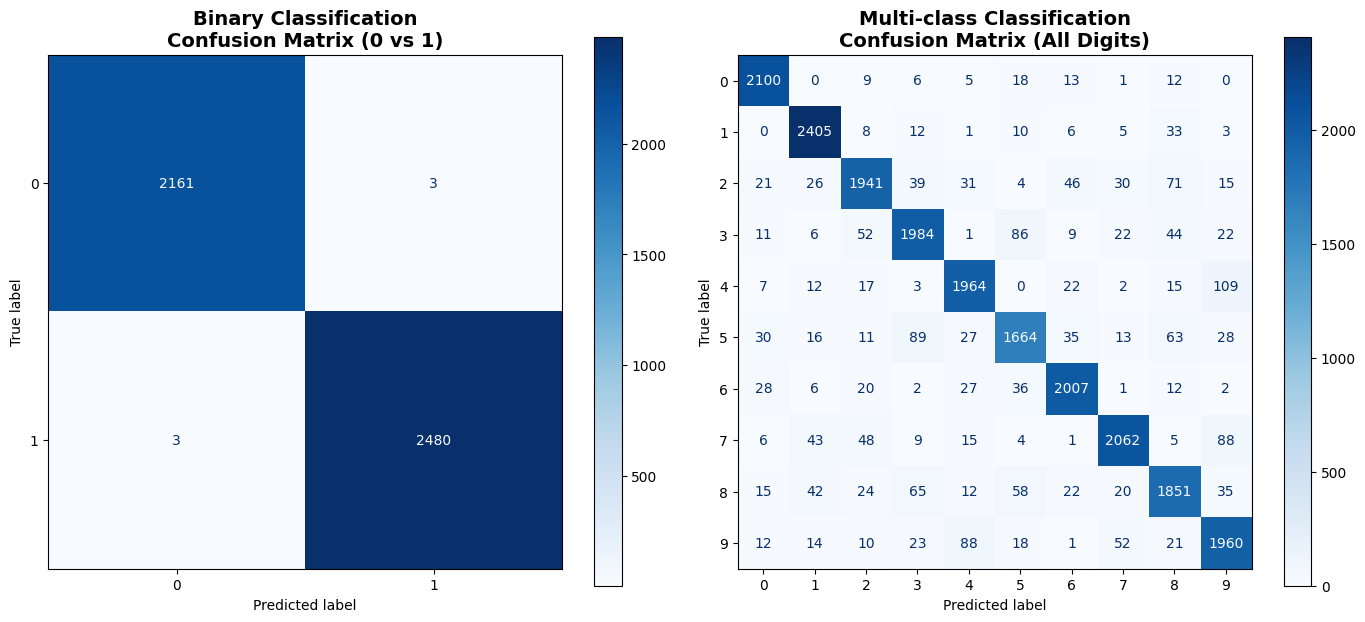

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
cm_bin = confusion_matrix(test_labels_bin, test_preds_bin)
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['0', '1'])
disp_bin.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Binary Classification\nConfusion Matrix (0 vs 1)', fontsize=14, fontweight='bold')
cm_multi = confusion_matrix(test_labels_multi, test_preds_multi)
disp_multi = ConfusionMatrixDisplay(confusion_matrix=cm_multi,
                                   display_labels=[str(i) for i in range(10)])
disp_multi.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Multi-class Classification\nConfusion Matrix (All Digits)',
                  fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### Per-class accuracy bar chart

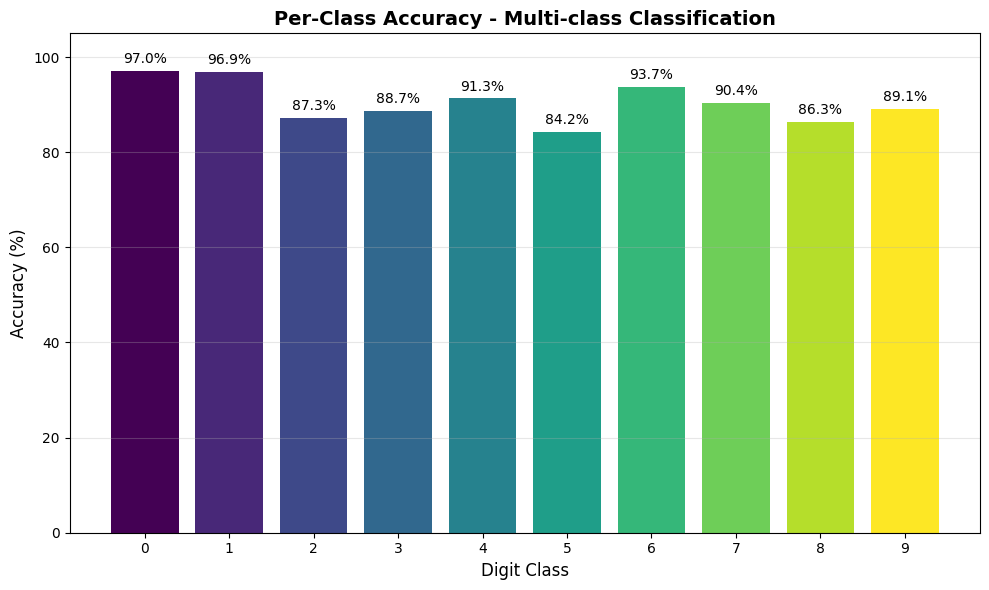

In [27]:
plt.figure(figsize=(10, 6))
bars = plt.bar(range(multi_model.n_classes), per_class_acc.numpy() * 100,
               color=plt.cm.viridis(np.linspace(0, 1, multi_model.n_classes)))
plt.xlabel('Digit Class', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Per-Class Accuracy - Multi-class Classification', fontsize=14, fontweight='bold')
plt.xticks(range(multi_model.n_classes))
plt.ylim([0, 105])
plt.grid(True, axis='y', alpha=0.3)

for i, (bar, acc) in enumerate(zip(bars, per_class_acc)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc*100:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## A5. Final Summary

In [30]:
print("\n BINARY CLASSIFICATION (Logistic Regression):")
print(f"  Final Train Accuracy: {bin_model.train_accs_bin[-1]:.4f}")
print(f"  Final Val Accuracy: {bin_model.val_accs_bin[-1]:.4f}")
print(f"  Final Test Accuracy: {test_acc_bin:.4f}")
print(f"  Final Train Loss: {bin_model.train_losses_bin[-1]:.4f}")
print(f"  Final Val Loss: {bin_model.val_losses_bin[-1]:.4f}")

tn, fp, fn, tp = cm_bin.ravel()
precision_bin = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_bin = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_bin = 2 * (precision_bin * recall_bin) / (precision_bin + recall_bin) if (precision_bin + recall_bin) > 0 else 0

print(f"\n  Additional Metrics:")
print(f"    Precision: {precision_bin:.4f}")
print(f"    Recall: {recall_bin:.4f}")
print(f"    F1-Score: {f1_bin:.4f}")

print("_"*50)

print("\n MULTI-CLASS CLASSIFICATION (Softmax Regression):")
print(f"  Final Train Accuracy: {multi_model.train_accs_multi[-1]:.4f}")
print(f"  Final Val Accuracy: {multi_model.val_accs_multi[-1]:.4f}")
print(f"  Final Test Accuracy: {test_acc_multi:.4f}")
print(f"  Final Train Loss: {multi_model.train_losses_multi[-1]:.4f}")
print(f"  Final Val Loss: {multi_model.val_losses_multi[-1]:.4f}")

print(f"\n  Best Performing Digit: {torch.argmax(per_class_acc).item()} "
      f"({per_class_acc[torch.argmax(per_class_acc)]*100:.2f}%)")
print(f"  Worst Performing Digit: {torch.argmin(per_class_acc).item()} "
      f"({per_class_acc[torch.argmin(per_class_acc)]*100:.2f}%)")
from sklearn.metrics import precision_recall_fscore_support

precision_multi, recall_multi, f1_multi, _ = precision_recall_fscore_support(
    test_labels_multi, test_preds_multi, average='weighted'
)

print("\n Additional Metrics:")
print(f"  Precision (weighted): {precision_multi:.4f}")
print(f"  Recall (weighted): {recall_multi:.4f}")
print(f"  F1-Score (weighted): {f1_multi:.4f}")


 BINARY CLASSIFICATION (Logistic Regression):
  Final Train Accuracy: 0.9979
  Final Val Accuracy: 0.9964
  Final Test Accuracy: 0.9987
  Final Train Loss: 0.0132
  Final Val Loss: 0.0168

  Additional Metrics:
    Precision: 0.9988
    Recall: 0.9988
    F1-Score: 0.9988
__________________________________________________

 MULTI-CLASS CLASSIFICATION (Softmax Regression):
  Final Train Accuracy: 0.9054
  Final Val Accuracy: 0.9042
  Final Test Accuracy: 0.9063
  Final Train Loss: 0.3386
  Final Val Loss: 0.3563

  Best Performing Digit: 0 (97.04%)
  Worst Performing Digit: 5 (84.21%)

 Additional Metrics:
  Precision (weighted): 0.9061
  Recall (weighted): 0.9063
  F1-Score (weighted): 0.9060


## A6. Saving the models

In [ ]:
model_dir = "classification_models"
os.makedirs(model_dir, exist_ok=True)

# Saving the binary model (weights and bias)
torch.save({
    'W_bin': bin_model.W_bin,
    'b_bin': bin_model.b_bin,
}, os.path.join(model_dir, "binary_logistic_regression_model.pth"))

# Saving the multi-class model (weights and bias)
torch.save({
    'W_multi': multi_model.W_multi,
    'b_multi': multi_model.b_multi,
}, os.path.join(model_dir, 'multi_class_softmax_regression_model.pth'))

print("Binary and multi-class models saved successfully!")